In [1]:
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.base import clone
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
sns.set()

In [2]:
# download mnist dataset
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
 X, y = mnist["data"], mnist["target"]

In [4]:
X.shape, y.shape

((70000, 784), (70000,))

(-0.5, 27.5, 27.5, -0.5)

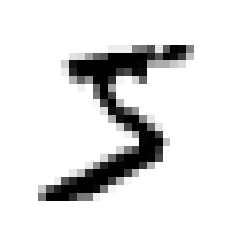

In [5]:
# display image
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")

In [6]:
y[0]

'5'

In [7]:
# convert labels to int
y = y.astype(np.uint8)

In [8]:
# split into train and test set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [9]:
# train binary classifier for detecting if digit is 5 or not
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

In [10]:
# fit SGD Classifier 
# default loss function for SGD classifier is hinge loss which is SVM loss function
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

In [12]:
# custom cross validation

# create stratified sampling k fold times
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

# cross validation scotr
for train_index, test_index in skfolds.split(X_train, y_train_5):
    
    # clone estimator with same parameter without copying data on it was fit
    clone_clf = clone(sgd_clf)
    
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
   
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [13]:
# cross validation score using sklearn
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [14]:
# create a base estimator which predicts always 0 i.e. never 5
class Never5Classifier(BaseEstimator):

    def fit(self, X, y=None):
        pass

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [17]:
# cross validation predict gives clean prediction for each instance in the training set 
# “clean” meaning that the prediction is made by a model
# that never saw the data during training)
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [18]:
y_train_pred.shape,X_train.shape

((60000,), (60000, 784))

In [19]:
# row in a confusion matrix represents an actual class,
# column represents a predicted class.
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [20]:
# precision & recall
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [21]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [22]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [23]:
# SGD Classifier Decision Function returns score
# by default is score > 0 then it predict 1
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [24]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [25]:
# returns score using cross validation
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,method="decision_function")

In [26]:
# precision recall curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [27]:
# plot precision recall
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(15,6))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

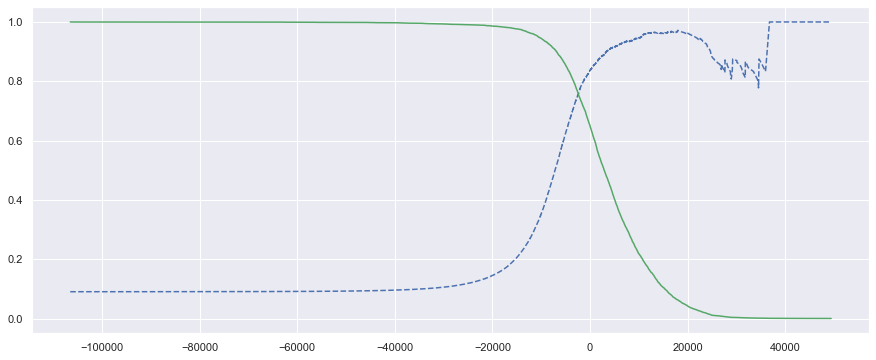

In [28]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [29]:
# plot precision vs recall
def plot_precision_vs_recall(precisions, recalls):
    plt.figure(figsize=(15,6))
    plt.plot(precisions, recalls, label="Precision vs Recall")
    plt.ylabel('Precision')
    plt.xlabel('Recall')

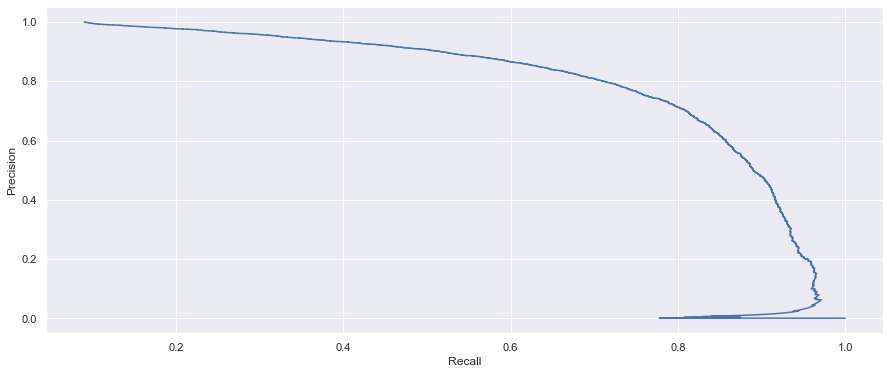

In [30]:
plot_precision_vs_recall(precisions, recalls)

In [31]:
# threhsold for 90% recall
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [32]:
# custom predict with custom thresholds
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [33]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

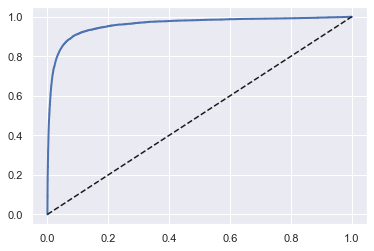

In [34]:
# roc curve
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
plot_roc_curve(fpr, tpr)

In [35]:
# roc auc score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [36]:
# fit random forest classifer
forest_clf = RandomForestClassifier(random_state=42)

# RandomForestClassifier class does not have a decision_function() method. 
# Instead it has a predict_proba() method

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,method="predict_proba")

In [37]:
y_probas_forest.shape

(60000, 2)

In [38]:
# score = proba of positive class
y_scores_forest = y_probas_forest[:, 1] 

# roc score
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

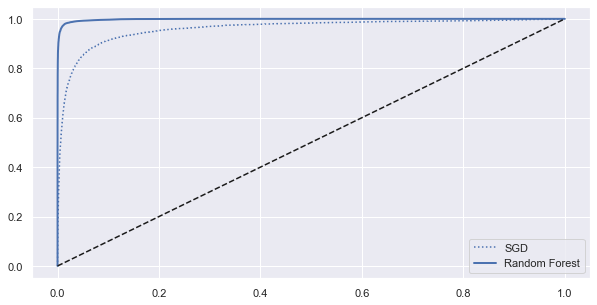

In [39]:
# compare both models
plt.figure(figsize=(10,5))
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")

In [40]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [41]:
# multinomail classification using SGD using OvA strategy
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [42]:
# Under the hood, Scikit-Learn actually trained 10 binary classifiers, 
# got their decision scores for the image, and selected the class with the highest score
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [43]:
np.argmax(some_digit_scores)

3

In [44]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [45]:
# one vs one classifier using SGD
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [46]:
# n * (n-1)/2
# 10 * (10-1)/2
len(ovo_clf.estimators_)

45

In [47]:
# Random Forest Multinomial classifier
# Random Forest classifiers can directly classify instances into multiple classes. 
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [48]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [49]:
# cross validation score
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [50]:
# improving performance by scaling the dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [51]:
# confusion matrix for cross validation
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

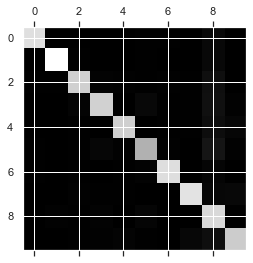

In [52]:
# plot confusion matrix
plt.matshow(conf_mx, cmap=plt.cm.gray)

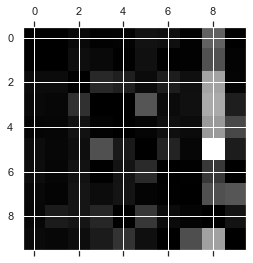

In [53]:
# plotting only error 
# filling diagonal to zero
# use error rates instead of raw numbers
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

In [54]:
# Multilabel Classification
# create a y_multilabel array containing two target labels for each digit image: 
# the first indicates whether or not the digit is large (7, 8, or 9)
# and the second indicates whether or not it is odd

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [55]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [56]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")  # macro giving equal wieghtage to each label

0.976410265560605

In [57]:
# Multioutput Classification
# creating data multiput classification dataset by adding noise to dataset

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

In [58]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

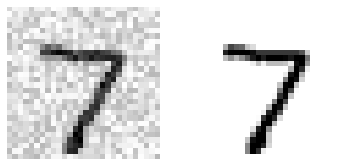

In [59]:
some_index = 0

plt.subplot(121)
plot_digit(X_test_mod[some_index])

plt.subplot(122)
plot_digit(y_test_mod[some_index])

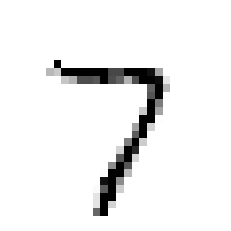

In [60]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit) 